In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [2]:
PATH = Path("/home/rob/code/Project/dataset/GTSRB/Training")
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [3]:
_N = 32
batch_size = 128
n_classes = 43
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale()
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0
    std = 0
    total = 0
    for images,_ in dataloader: # load a batch at a time
        total += 1
        mean  += images.mean()
        std   += images.std()
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor(0.3211), tensor(0.2230))

In [5]:
mean = 0.3211
std = 0.2230

def to_image(img): # convert to unormalized form for viewing

    return (img * std + mean).permute(1,2,0).numpy()

normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    normalise
])

In [6]:
_dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)

In [7]:

loader = torch.utils.data.DataLoader(_dataset, 
                                     batch_size=batch_size, 
                                     num_workers=6,
                                     shuffle=True
                                    )


In [8]:
GROUPS = [3,3,3,3,3,3,2,3,3,4,4,1,0,0,0,4,4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,5,5,5,5,5,5,5,5,2,2] 
GROUP_NAMES = ["Unique Signs","Danger Signs","Derestriction Signs","Speed Limit Signs","Other Prohibitory Signs","Mandatory Signs"]

In [9]:
GROUP_MATRIX = [[group == i for group in GROUPS] for i in range(6)]
print(str(GROUP_MATRIX).lower())

[[false, false, false, false, false, false, false, false, false, false, false, false, true, true, true, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false], [false, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, true, true, true, true, true, true, true, true, true, true, true, true, true, true, false, false, false, false, false, false, false, false, false, false, false], [false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, true, true], [true, true, true, true, true, true, false, true, true, false, false, false, false, false, false, false, false, f

In [10]:
plt.rc('axes', titlesize=8)

def show_groups(loader):
    plt.figure(figsize=(15,7))
    images = torch.zeros((n_classes,3,_N,_N))

    for imgs,lbls in loader:
        for img,lbl in zip(imgs,lbls):
            images[lbl] = img
    for i, img in enumerate(images):
        plt.subplot(4,11, i + 1)
        plt.imshow(to_image(img))
        plt.title(f"{GROUP_NAMES[GROUPS[i]]}")
        plt.axis("off")
    plt.tight_layout()


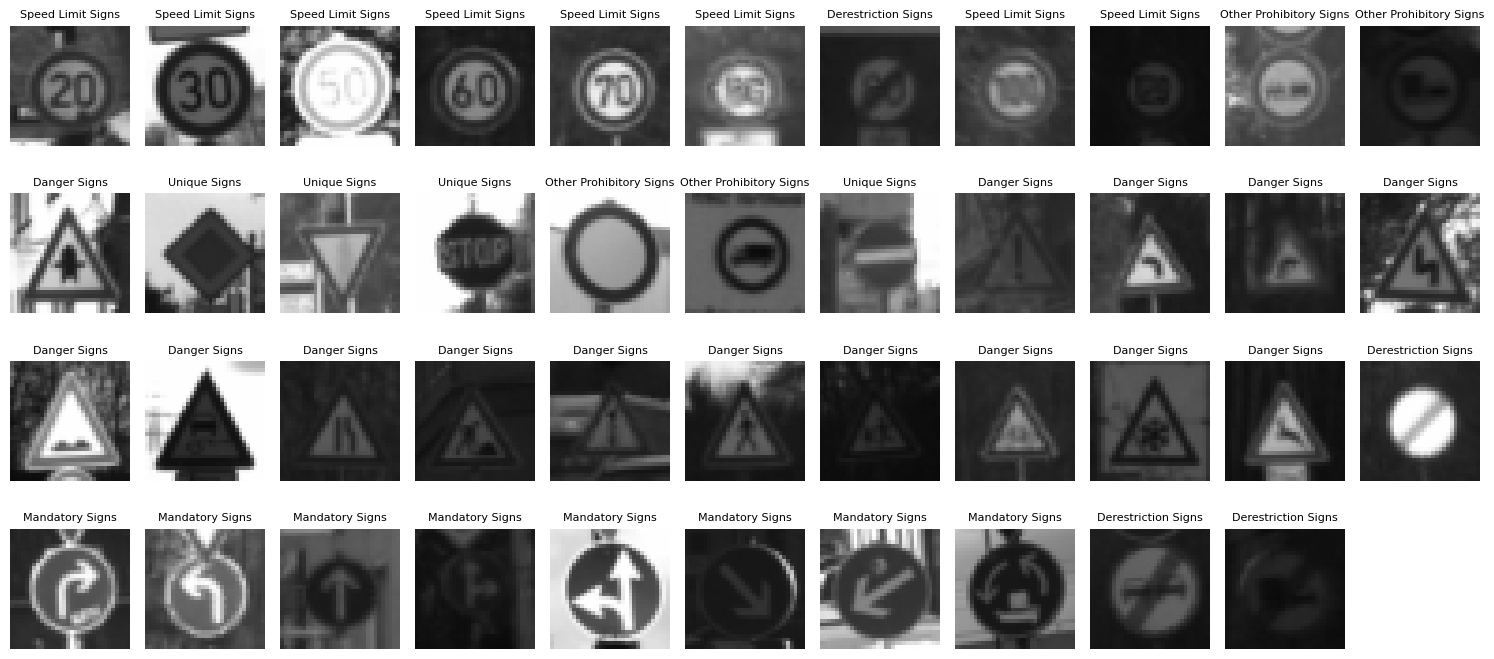

In [11]:
show_groups(loader)

In [12]:
def filter_dataset(dataset):
    groups_to_keep = {2,3,5}
    labels_to_keep = {i for i in range(43) if GROUPS[i] in groups_to_keep}
    to_keep = [i for i,(_,label) in enumerate(dataset) if label in labels_to_keep]
    new_label_mapping = {old : new for new,old in enumerate(labels_to_keep)}
    remap = lambda x : new_label_mapping[x]
    dataset.target_transform = remap
    filtered_dataset = torch.utils.data.Subset(dataset,to_keep)
    return filtered_dataset, new_label_mapping
filtered_dataset, mapping = filter_dataset(_dataset)
n_classes = len(mapping)

In [ ]:
def update_groups(GROUPS):
    GROUP_NAMES = ["Derestriction Signs","Speed Limit Signs","Mandatory Signs"]
    remap = {2 : 0, 3 : 1, 5 : 2}
    print(list(i for i in mapping))
    groups = [remap[GROUPS[old]] for old in mapping]
    print(groups)
    return groups, GROUP_NAMES
GROUPS, GROUP_NAMES = update_groups(GROUPS)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]


In [14]:
train_dataset, test_dataset = torch.utils.data.random_split(filtered_dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

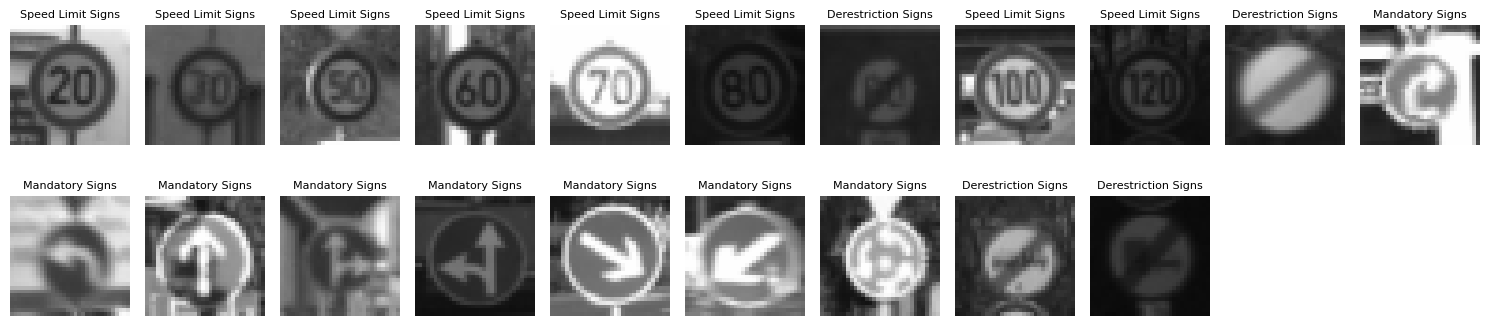

In [15]:
show_groups(train_loader)

In [17]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((batch_size,1,_N,_N))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)

    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = Model().to(device)
summary(model,(1,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 28, 28]             156
         MaxPool2d-2           [128, 6, 14, 14]               0
            Conv2d-3          [128, 16, 10, 10]           2,416
         MaxPool2d-4            [128, 16, 5, 5]               0
            Linear-5                 [128, 128]          51,328
            Linear-6                  [128, 64]           8,256
            Linear-7                  [128, 20]           1,300
Total params: 63,456
Trainable params: 63,456
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 7.90
Params size (MB): 0.24
Estimated Total Size (MB): 8.64
----------------------------------------------------------------


In [18]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [ ]:
def train(model,loss_func,optimiser,epochs):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")

def test_performance(model,loss_func):
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss += loss_func(preds,labels).item()
    return loss / len(test_loader)

In [20]:
train(model,loss_func,optimiser,epochs)

Epoch 1 --- Training Loss 2.174 --- Validation Loss 1.476
Epoch 2 --- Training Loss 0.971 --- Validation Loss 0.692
Epoch 3 --- Training Loss 0.510 --- Validation Loss 0.464
Epoch 4 --- Training Loss 0.345 --- Validation Loss 0.292
Epoch 5 --- Training Loss 0.240 --- Validation Loss 0.231
Epoch 6 --- Training Loss 0.180 --- Validation Loss 0.197
Epoch 7 --- Training Loss 0.144 --- Validation Loss 0.173
Epoch 8 --- Training Loss 0.120 --- Validation Loss 0.150
Epoch 9 --- Training Loss 0.097 --- Validation Loss 0.134
Epoch 10 --- Training Loss 0.089 --- Validation Loss 0.123
Epoch 11 --- Training Loss 0.070 --- Validation Loss 0.136
Epoch 12 --- Training Loss 0.061 --- Validation Loss 0.113
Epoch 13 --- Training Loss 0.051 --- Validation Loss 0.111
Epoch 14 --- Training Loss 0.045 --- Validation Loss 0.093
Epoch 15 --- Training Loss 0.037 --- Validation Loss 0.088
Epoch 16 --- Training Loss 0.040 --- Validation Loss 0.092
Epoch 17 --- Training Loss 0.027 --- Validation Loss 0.090
Epoch 

In [21]:
def save_model(model,name):
    inputs = torch.rand((batch_size,1,_N,_N),requires_grad=True).to(device)
    torch.onnx.export(model,inputs,f"models/{name}.onnx",input_names=["input"],output_names=["output"],dynamic_axes={'input': { 0: 'batch_size' }, 'output': { 0: 'batch_size' }})
save_model(model,"model")

In [22]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.9858
Recall (macro): 0.9857
F1-score (macro): 0.9857


In [ ]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(decay_rate,1,iterations,2)
    decay = decay / decay[0]
    decay *= learning_rate
    
    momentum = torch.zeros(images.shape).to(device)

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data)
        
        adversarial += (perturbations + momentum) * alpha

        momentum = momentum * momentum_decay + (1 - momentum_decay) * perturbations

        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)



normalise.to(device)

@torch.compile
def denormalise(images):
    return images * std + mean


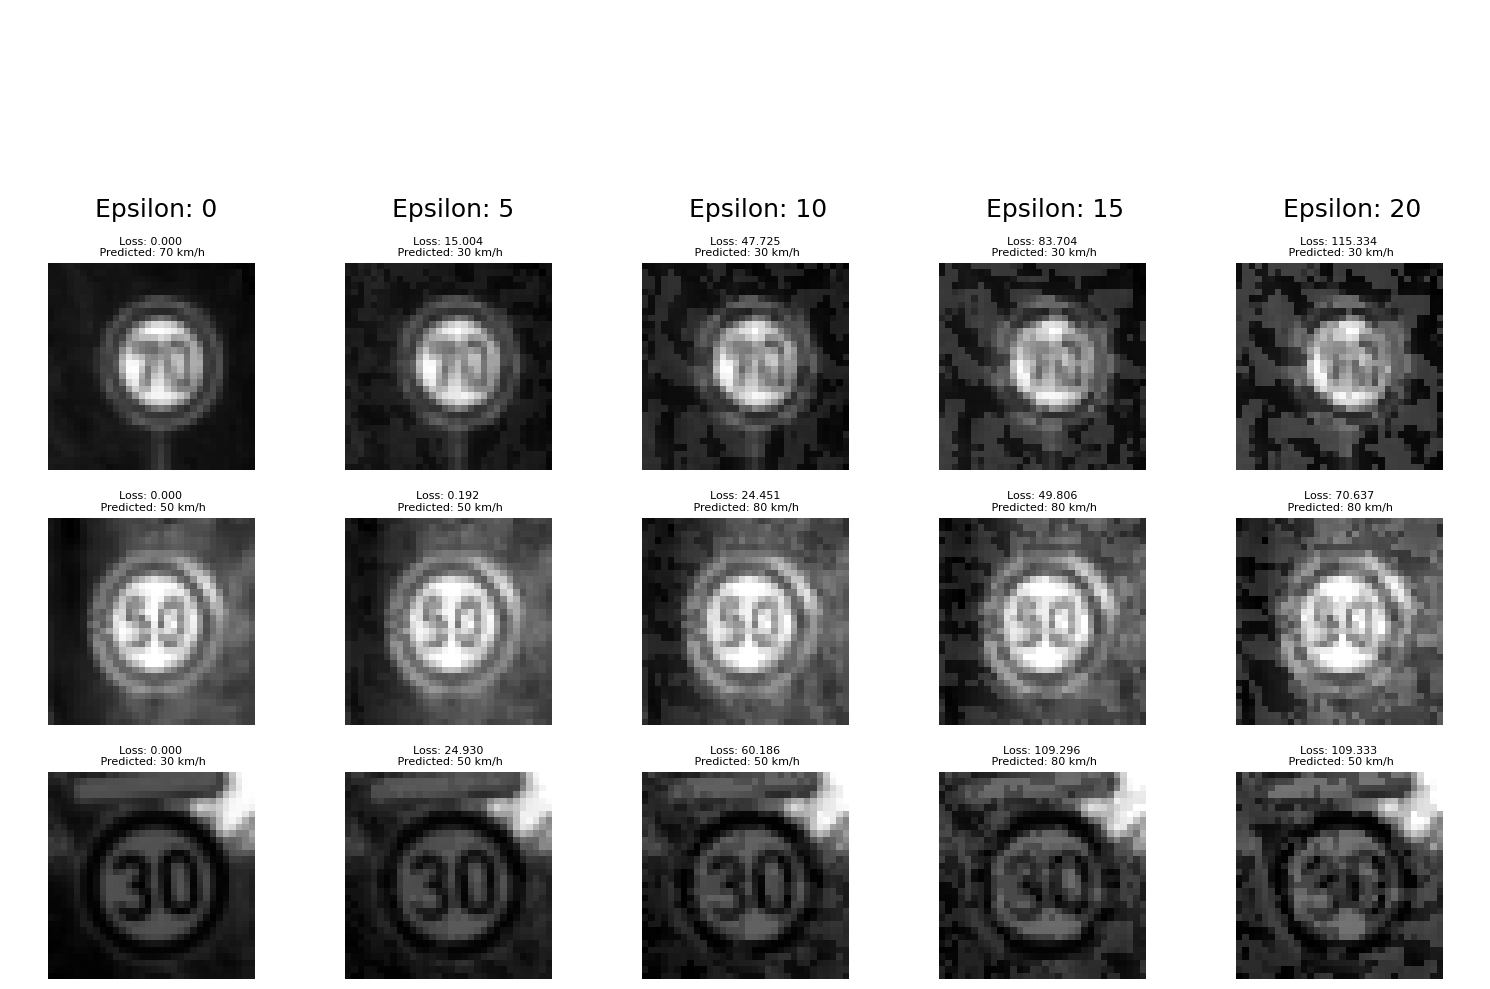

In [19]:
def adversarial_test(model):
    for img,lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        rows = 4
        columns = 5
        decay_rate = 6
        learning_rate = 40 / 255
        momentum_decay = 0.8
        iterations = 40
        epsilon = 0.078
        plt.figure(figsize=(15, 10))
        multiplier = 5
        for j in range(columns):
            epsilon = j * multiplier
            plt.subplot(rows, columns, j + 1)
            plt.axis("off")
            plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

            

        for j in range(columns):
            epsilon = j * multiplier / 255
            adv = pgd_attack(model,img,lbl,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
            for i in range(1,rows):
                plt.subplot(rows, columns, i * columns + j + 1)
                pred = model(adv[i].reshape(1,1,_N,_N))
                loss = loss_func(pred,lbl[i].reshape(1)).data
                pred_class = LABELS[torch.argmax(pred)]
                pred_class = pred_class[:12] + "..." if len(pred_class) > 12 else pred_class
                plt.imshow(to_image(adv[i].cpu()),cmap="grey")
                plt.title(f"Loss: {loss:.3f}\n Predicted: {pred_class}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Gets errors for images being out of 0-1 range, probably floating point inaccuracy
        break
adversarial_test(model)

In [13]:
def adversarial_training(model,loss_func,optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            images = torch.cat((images,
                pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
                ))
            labels = torch.cat((labels,labels))

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")


In [16]:
adversarial_model = Model().to(device)
adversarial_model.load_state_dict(torch.load("models/base_epsilon_0.078.pth",weights_only=True))
adv_optimiser = torch.optim.Adam(adversarial_model.parameters())#torch.optim.SGD(adversarial_model.parameters(),lr=0.01, momentum=0.9)

In [25]:
decay_rate = 6
learning_rate = 40 / 255
momentum_decay = 0.8
iterations = 40
epsilon = 0.078
epochs = 50
adversarial_training(model,loss_func,optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay)

Epoch 1 --- Training Loss 1.904 --- Validation Loss 1.063
Epoch 2 --- Training Loss 1.902 --- Validation Loss 1.049
Epoch 3 --- Training Loss 1.902 --- Validation Loss 1.033
Epoch 4 --- Training Loss 1.900 --- Validation Loss 1.036
Epoch 5 --- Training Loss 1.898 --- Validation Loss 1.044
Epoch 6 --- Training Loss 1.901 --- Validation Loss 1.028
Epoch 7 --- Training Loss 1.895 --- Validation Loss 1.032
Epoch 8 --- Training Loss 1.897 --- Validation Loss 1.028
Epoch 9 --- Training Loss 1.891 --- Validation Loss 1.022
Epoch 10 --- Training Loss 1.885 --- Validation Loss 1.018
Epoch 11 --- Training Loss 1.887 --- Validation Loss 1.015
Epoch 12 --- Training Loss 1.888 --- Validation Loss 1.006
Epoch 13 --- Training Loss 1.882 --- Validation Loss 1.007
Epoch 14 --- Training Loss 1.879 --- Validation Loss 1.015
Epoch 15 --- Training Loss 1.883 --- Validation Loss 1.013
Epoch 16 --- Training Loss 1.879 --- Validation Loss 1.006
Epoch 17 --- Training Loss 1.882 --- Validation Loss 0.997
Epoch 

In [28]:
evaluate(adversarial_model)

Precision (macro): 0.8148
Recall (macro): 0.7090
F1-score (macro): 0.7344


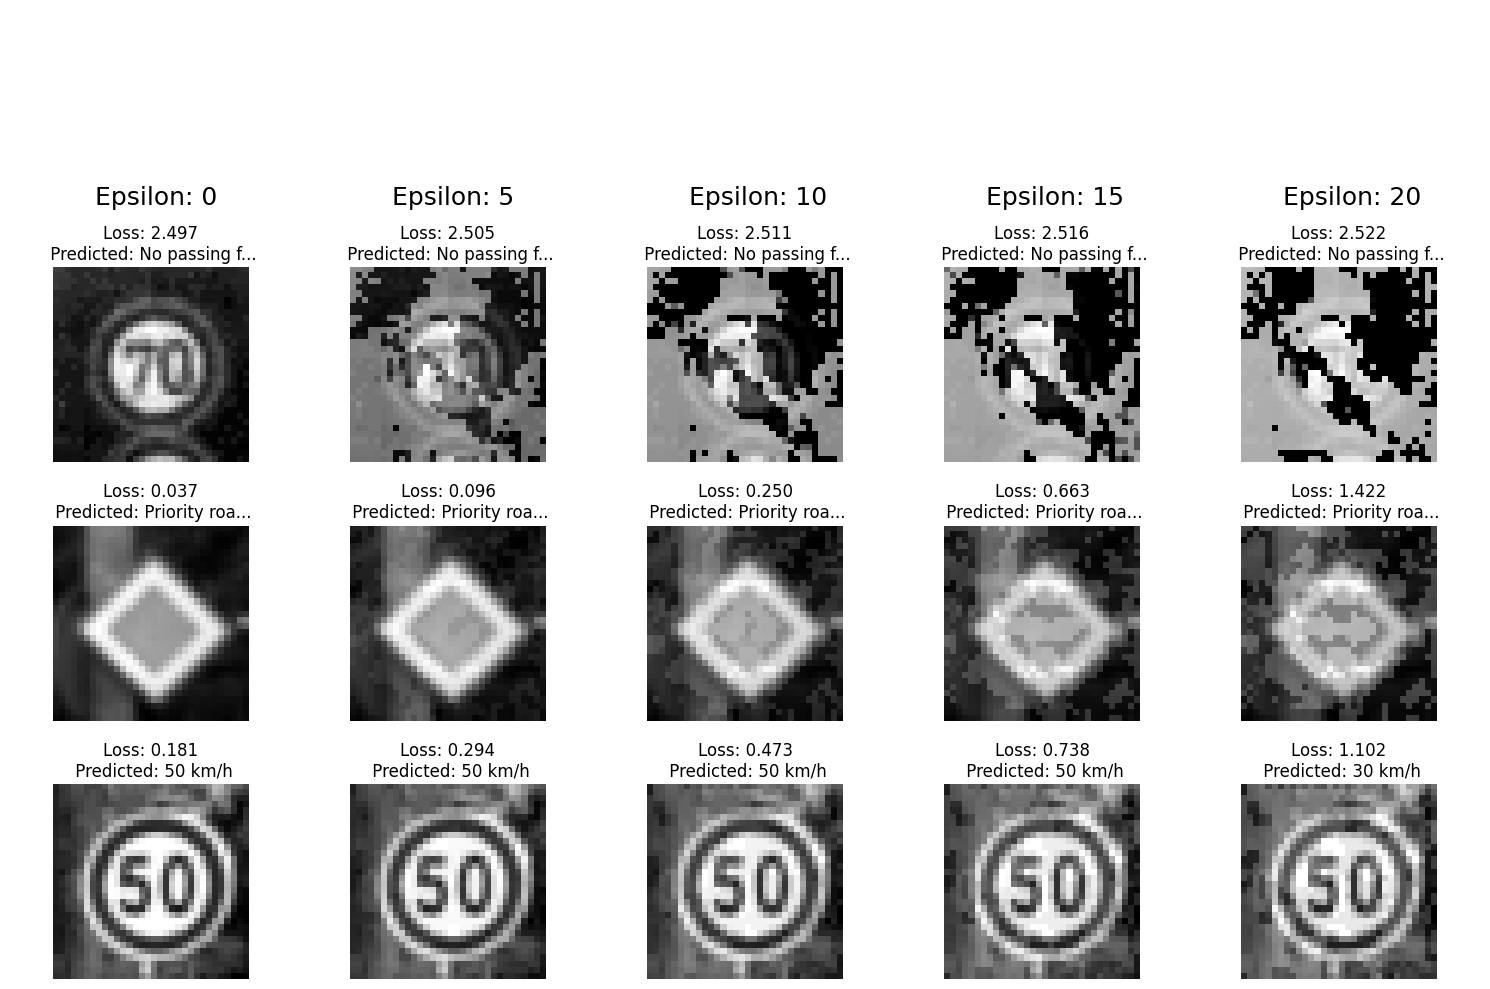

In [31]:
adversarial_test(adversarial_model)

In [78]:
torch.save(adversarial_model.state_dict(),f"models/adversarial_model_grey_{epsilon*255}.pth")